In [2]:
'''
实现wide&deep算法：keras、pytorch，用于分类和回归模型。
主要用pytorch实现的wide&deep model。
'''

'\n实现wide&deep算法：keras、pytorch，用于分类和回归模型。\n主要用pytorch实现的wide&deep model。\n'

# demo-keras

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model

Using TensorFlow backend.
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

In [4]:
COLUMNS = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status", 
    "occupation", "relationship", "race", "gender", "capital_gain", "capital_loss", 
    "hours_per_week", "native_country", "income_bracket"
]

LABEL_COLUMN = "label"

CATEGORICAL_COLUMNS = [
    "workclass", "education", "marital_status", "occupation", "relationship", 
    "race", "gender", "native_country"
] #非数字的列，分类数据

CONTINUOUS_COLUMNS = [
    "age", "education_num", "capital_gain", "capital_loss", "hours_per_week"
] #连续数据对应的列

## process data

In [5]:
def preprocessing(): #数据集处理
    train_data = pd.read_csv('./data/adult.data', names=COLUMNS) #打开adult.data训练数据集，列名是COLUMNS
    train_data.dropna(how='any', axis=0) #删除带有空值的行，只要有一个空值，就删除整行
    test_data = pd.read_csv('./data/adult.test', skiprows=1, names=COLUMNS) #打开adult.test测试数据集
    test_data.dropna(how='any', axis=0) #删除带有空值的行，只要有一个空值，就删除整行
    all_data = pd.concat([train_data, test_data]) #将训练集和测试集拼接在一起
    # 数値化
    all_data[LABEL_COLUMN] = all_data['income_bracket'].apply(lambda x: ">50K" in x).astype(int) #添加一列标签，收入<=50K令其为0，>50K令其为1
    all_data.pop('income_bracket') #将原收入那一列删除
    y = all_data[LABEL_COLUMN].values #y为标签
    all_data.pop(LABEL_COLUMN) #处理完后进行删除
    for c in CATEGORICAL_COLUMNS:
        le = LabelEncoder() #使用sklearn中的LabelEncoder()进行编码
        all_data[c] = le.fit_transform(all_data[c])
    train_size = len(train_data) #获取训练集的大小
    x_train = all_data.iloc[:train_size] #x_train表示前train_size个数据是训练集
    y_train = y[:train_size] #y_train表示y中前train_size个数据是训练集对应的标签
    x_test = all_data.iloc[train_size:] #测试集数据
    y_test = y[train_size:] #测试集标签
    
    x_train_categ = np.array(x_train[CATEGORICAL_COLUMNS]) #训练集中的类别数据，转成numpy类型
    x_test_categ = np.array(x_test[CATEGORICAL_COLUMNS]) #测试集中的类别类别数据
    x_train_conti = np.array(x_train[CONTINUOUS_COLUMNS], dtype='float64') # 训练集中的连续数据
    x_test_conti = np.array(x_test[CONTINUOUS_COLUMNS], dtype='float64') #测试集中的连续数据，
    scaler = StandardScaler()
    x_train_conti = scaler.fit_transform(x_train_conti) # 连续训练数据标准化
    x_test_conti = scaler.transform(x_test_conti)
    return [x_train, y_train, x_test, y_test, x_train_categ, x_test_categ, x_train_conti, x_test_conti, all_data]

## model

In [6]:
class Wide_and_Deep:
    def __init__(self, mode='wide and deep'):
        self.mode = mode
        x_train, y_train, x_test, y_test, x_train_categ, x_test_categ, x_train_conti, x_test_conti, all_data \
            = preprocessing()
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.x_train_categ = x_train_categ 
        self.x_test_categ = x_test_categ 
        self.x_train_conti = x_train_conti 
        self.x_test_conti = x_test_conti 
        self.all_data = all_data
        # 构造多项式特征，cross-product transformation
        self.poly = PolynomialFeatures(degree=2, interaction_only=True)
        # 将分类数据进行cross product化
        self.x_train_categ_poly = self.poly.fit_transform(x_train_categ)
        self.x_test_categ_poly = self.poly.transform(x_test_categ)
        self.categ_inputs = None
        self.conti_input = None
        self.deep_component_outlayer = None
        self.logistic_input = None
        self.model = None

    def deep_component(self):
        categ_inputs = []
        categ_embeds = [] # 类别特征embedding后的低维特征
        # 按分类数据的特征分别创建Input层和Embeding层
        for i in range(len(CATEGORICAL_COLUMNS)):
            input_i = Input(shape=(1,), dtype='int32')
            dim = len(np.unique(self.all_data[CATEGORICAL_COLUMNS[i]]))
            embed_dim = int(np.ceil(dim ** 0.25)) 
            embed_i = Embedding(dim, embed_dim, input_length=1)(input_i)
            flatten_i = Flatten()(embed_i)
            categ_inputs.append(input_i)
            categ_embeds.append(flatten_i)
        # 在所有结合层中统一输入连续数据
        conti_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
        conti_dense = Dense(256, use_bias=False)(conti_input)
        # 将所有结合层和每个Embeding的输出相结合
        concat_embeds = concatenate([conti_dense]+categ_embeds)
        concat_embeds = Activation('relu')(concat_embeds)
        bn_concat = BatchNormalization()(concat_embeds)
        # 进一步将所有结合层重叠3层
        fc1 = Dense(512, use_bias=False)(bn_concat)
        ac1 = ReLU()(fc1)
        bn1 = BatchNormalization()(ac1)
        fc2 = Dense(256, use_bias=False)(bn1)
        ac2 = ReLU()(fc2)
        bn2 = BatchNormalization()(ac2)
        fc3 = Dense(128)(bn2)
        ac3 = ReLU()(fc3)

        # 将输入层和最后一层进行成员变量化（用于制作模型）
        self.categ_inputs = categ_inputs
        self.conti_input = conti_input
        self.deep_component_outlayer = ac3

    def wide_component(self):
        # 只将分类数据列入线性模型
        dim = self.x_train_categ_poly.shape[1]
        self.logistic_input = Input(shape=(dim,))

    def create_model(self):
        self.deep_component()
        self.wide_component()
        if self.mode == 'wide and deep':
            out_layer = concatenate([self.deep_component_outlayer, self.logistic_input])
            inputs = [self.conti_input] + self.categ_inputs + [self.logistic_input]
        elif self.mode =='deep':
            out_layer = self.deep_component_outlayer
            inputs = [self.conti_input] + self.categ_inputs
        else:
            print('wrong mode')
            return

        output = Dense(1, activation='sigmoid')(out_layer) #sigmoid函数作为最后一层的输出激活函数
        self.model = Model(inputs=inputs, outputs=output)

    def train_model(self, epochs=15, optimizer='adam', batch_size=128):
        if not self.model:
            print('You have to create model first')
            return

        if self.mode == 'wide and deep':
            input_data = [self.x_train_conti] +\
                         [self.x_train_categ[:, i] for i in range(self.x_train_categ.shape[1])] +\
                         [self.x_train_categ_poly]
        elif self.mode == 'deep':
            input_data = [self.x_train_conti] +\
                         [self.x_train_categ[:, i] for i in range(self.x_train_categ.shape[1])]
        else:
            print('wrong mode')
            return
        
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        self.model.fit(input_data, self.y_train, epochs=epochs, batch_size=batch_size)

    def evaluate_model(self):
        if not self.model:
            print('You have to create model first')
            return

        if self.mode == 'wide and deep':
            input_data = [self.x_test_conti] +\
                         [self.x_test_categ[:, i] for i in range(self.x_test_categ.shape[1])] +\
                         [self.x_test_categ_poly]
        elif self.mode == 'deep':
            input_data = [self.x_test_conti] +\
                         [self.x_test_categ[:, i] for i in range(self.x_test_categ.shape[1])]
        else:
            print('wrong mode')
            return

        loss, acc = self.model.evaluate(input_data, self.y_test)
        print(f'test_loss: {loss} - test_acc: {acc}')

    def save_model(self, filename='wide_and_deep.h5'):
        self.model.save(filename)

## implement

In [ ]:
if __name__ == '__main__':
    wide_deep_net = Wide_and_Deep()
    wide_deep_net.create_model()
    wide_deep_net.train_model()
    wide_deep_net.evaluate_model()
    wide_deep_net.save_model()

In [9]:
import os    
import pydotplus
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

In [10]:
print(wide_deep_net.model.summary()) # Summarize Model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

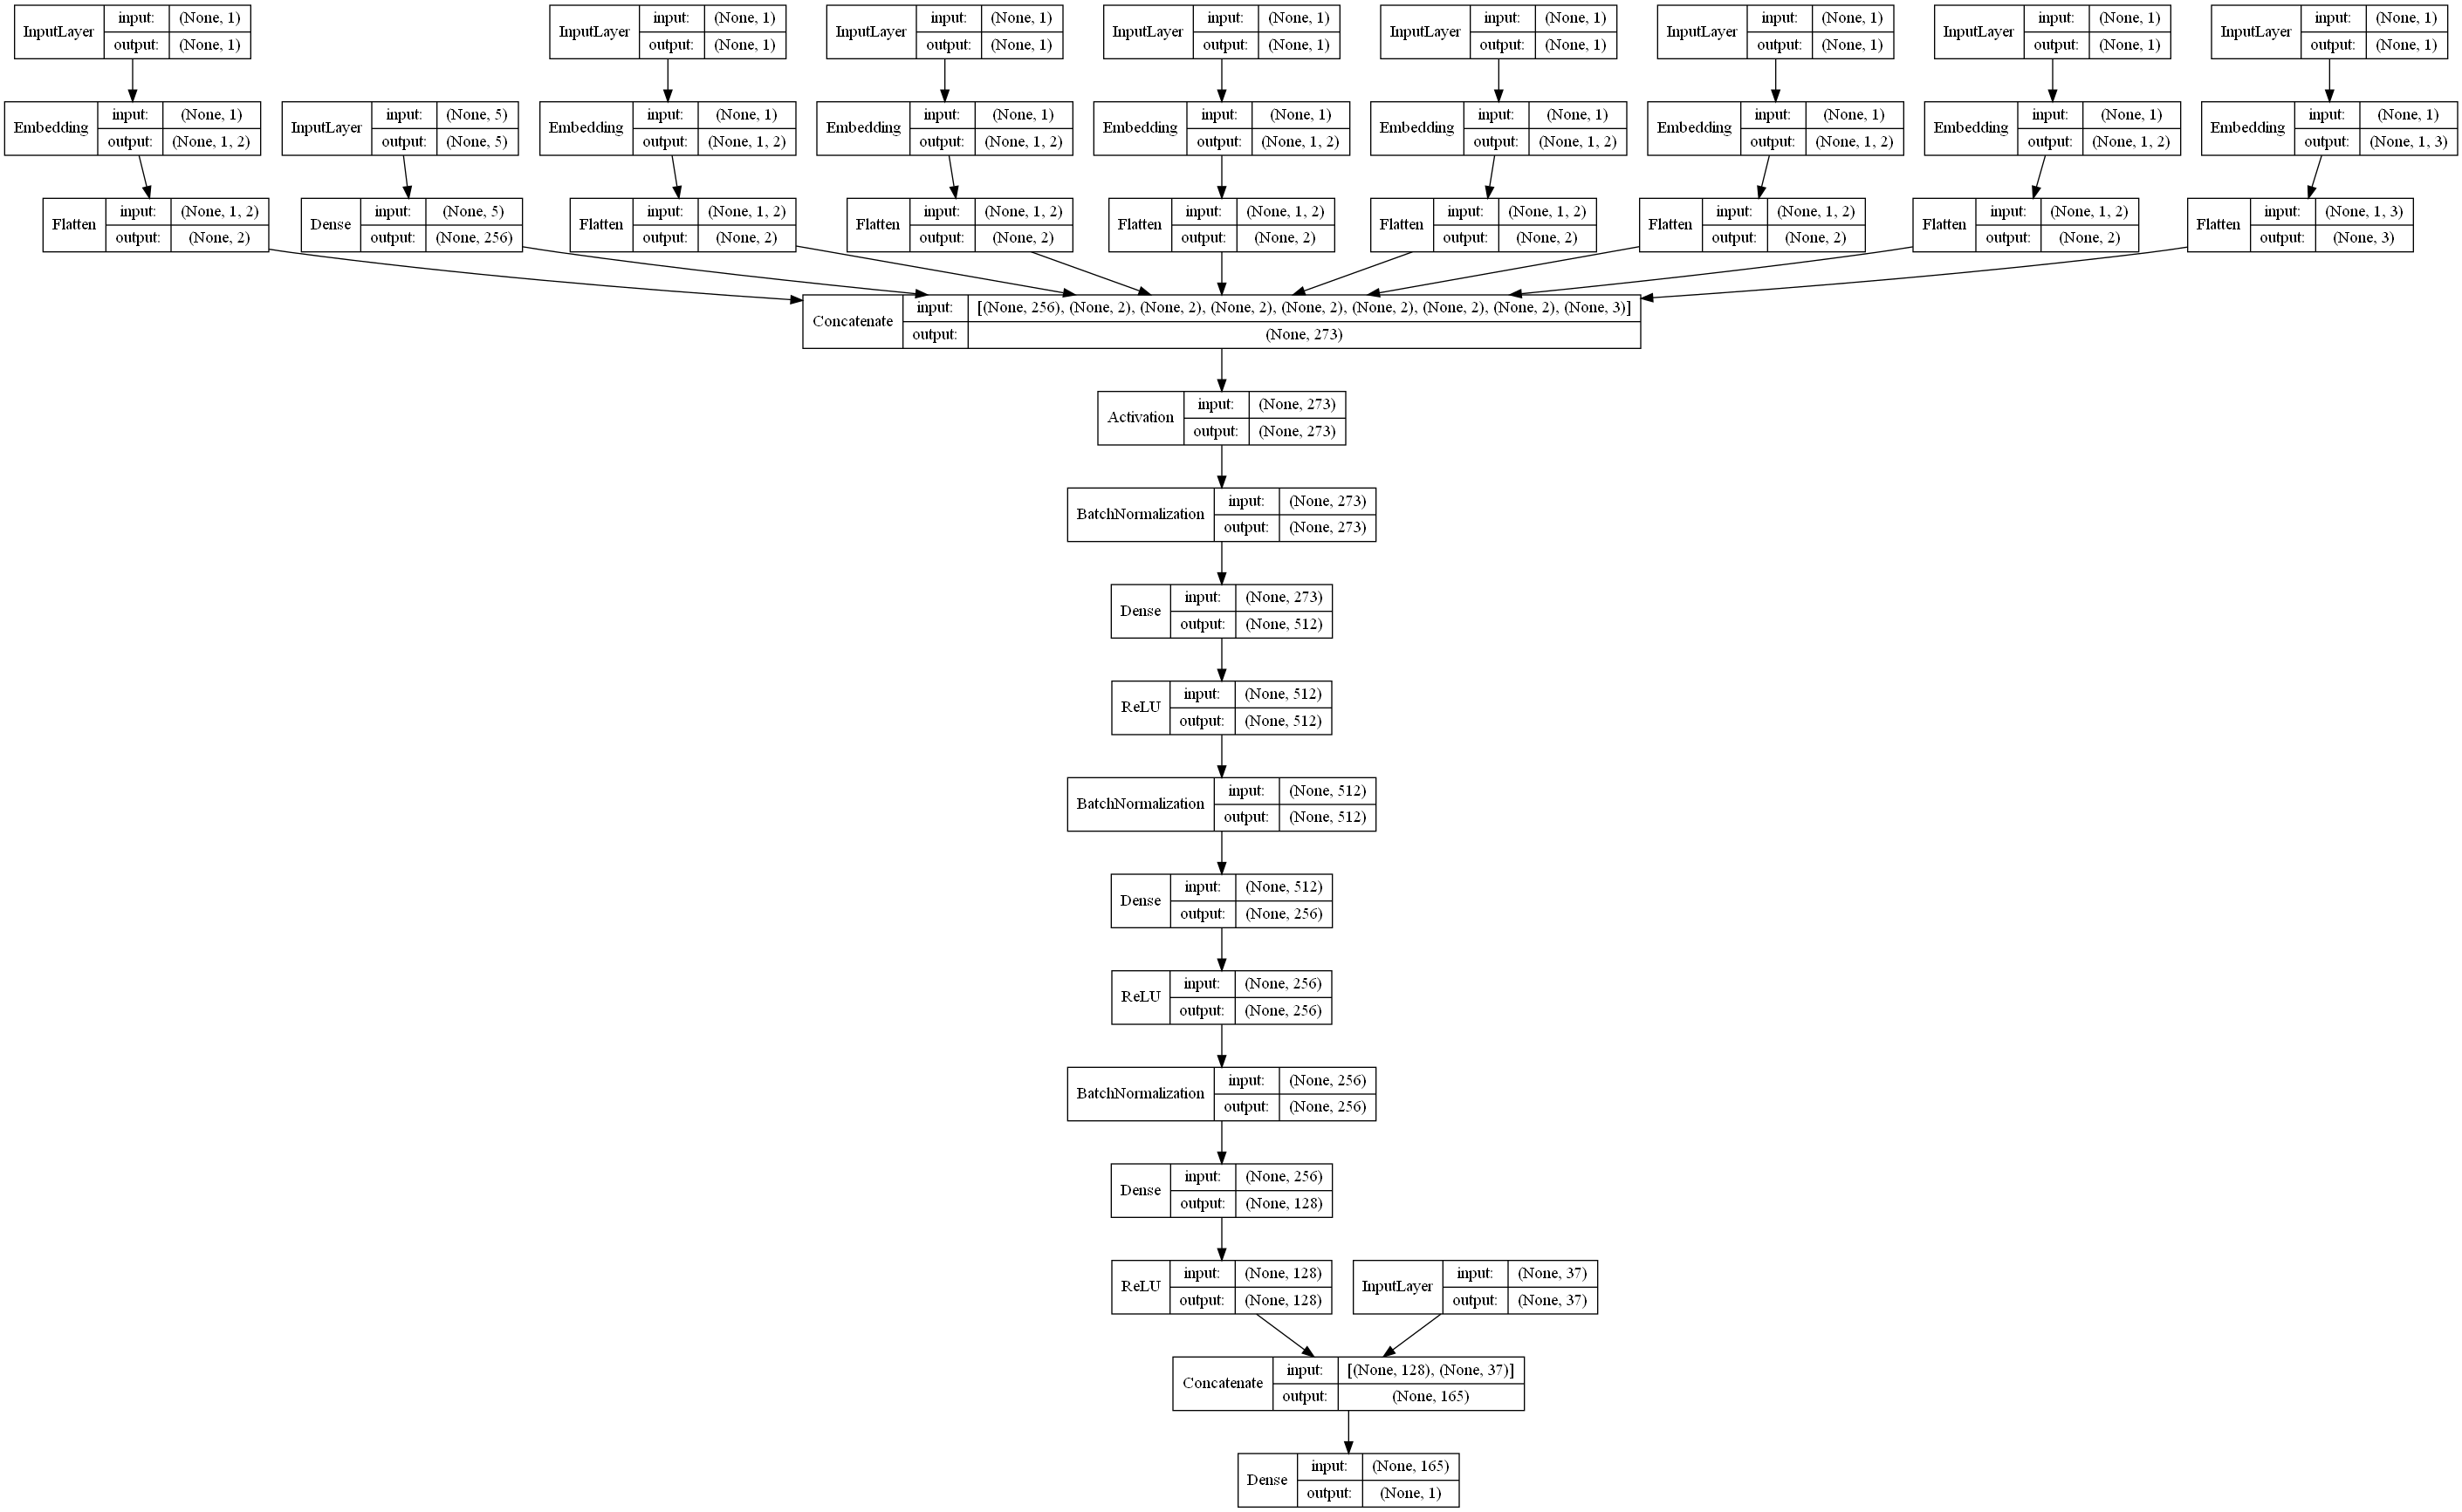

In [11]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(wide_deep_net.model, to_file='model.png', show_shapes=True, show_layer_names=False)

# demo-pytorch